In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical



In [3]:
df = pd.read_csv('/content/drive/MyDrive/Section4Project/icml_face_data.csv')

In [4]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
df[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [6]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [7]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [8]:
train_image_array, train_image_label = prepare_data(df[df[' Usage']=='Training'])
test_image_array, test_image_label = prepare_data(df[df[' Usage']=='PublicTest'])

In [9]:
X_train = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
X_train = X_train.astype('float32')/255
X_test = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
X_test = X_test.astype('float32')/255

In [10]:
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)
X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

In [11]:
y_train = to_categorical(train_image_label)
y_test = to_categorical(test_image_label)

In [12]:
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = df[df['emotion']==label].index[i]
        axs[i].imshow(X_train[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[y_train[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [13]:
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = df[df['emotion']==i].index[i]
        axs[i].imshow(X_train[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[y_train[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

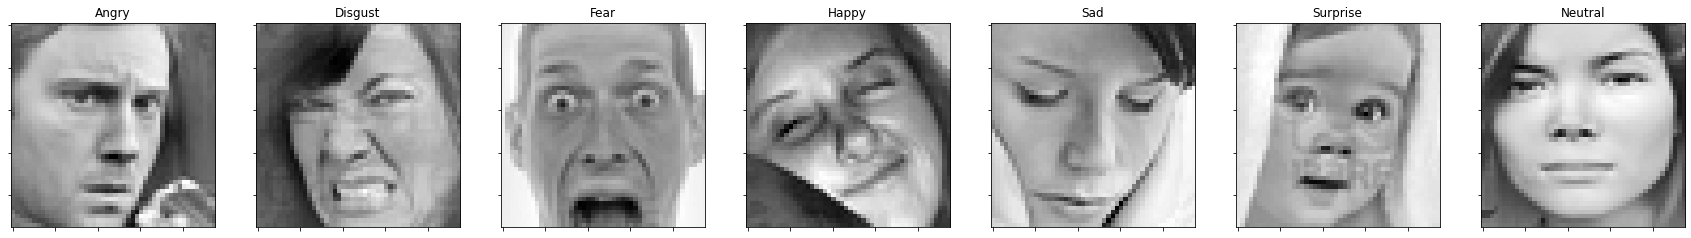

In [14]:
plot_all_emotions()

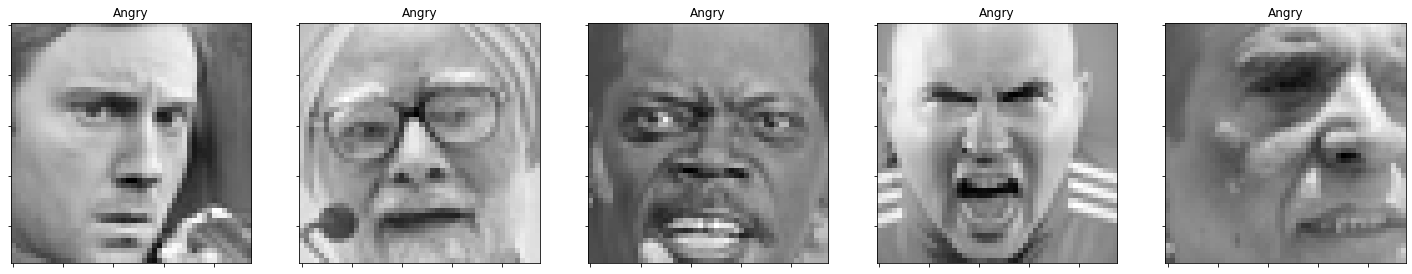

In [15]:
plot_examples(label=0)

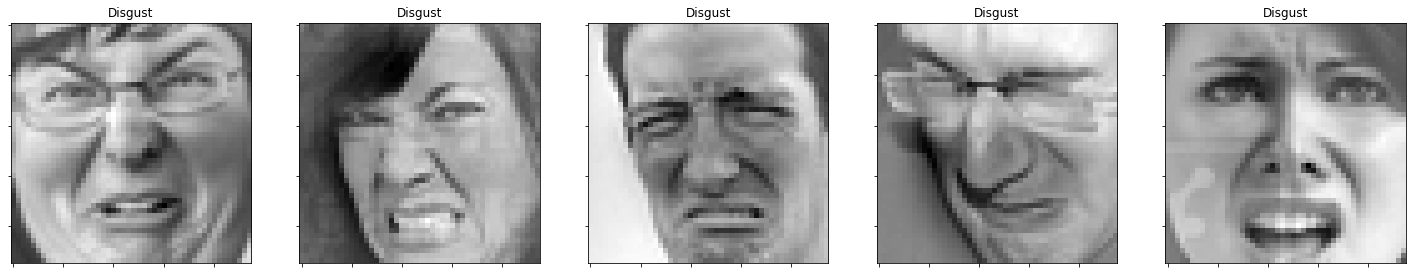

In [16]:
plot_examples(label=1)

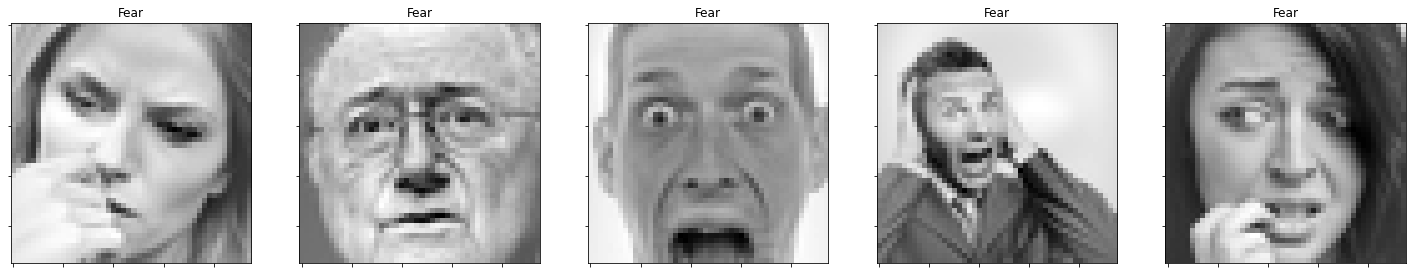

In [17]:
plot_examples(label=2)

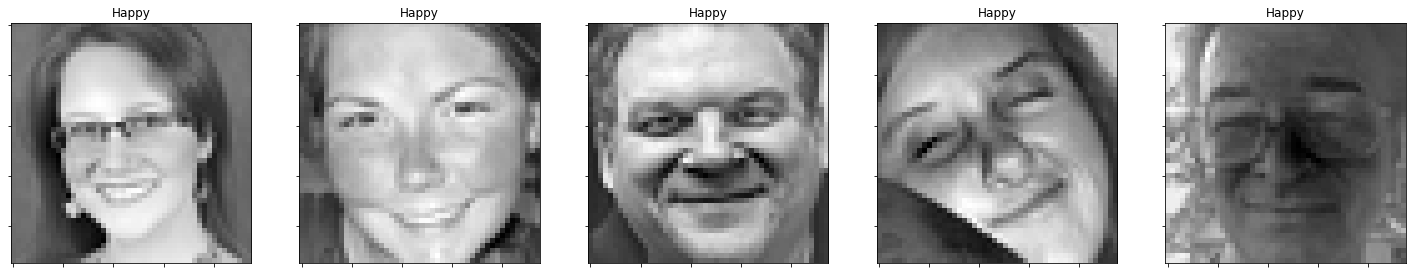

In [18]:
plot_examples(label=3)

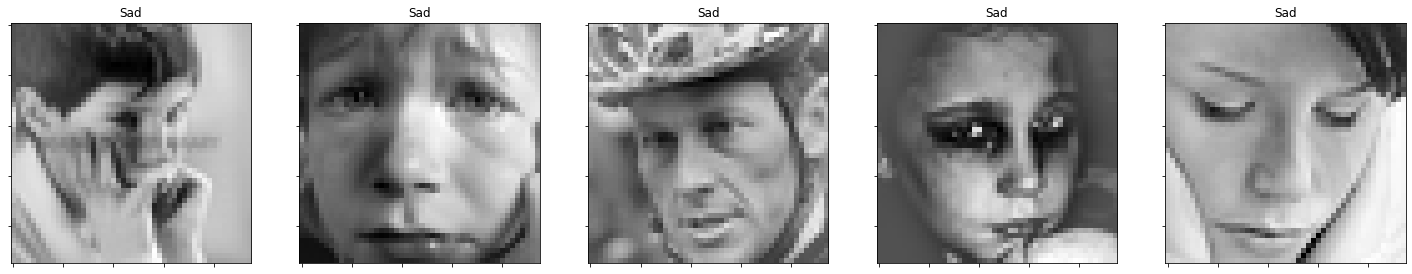

In [19]:
plot_examples(label=4)

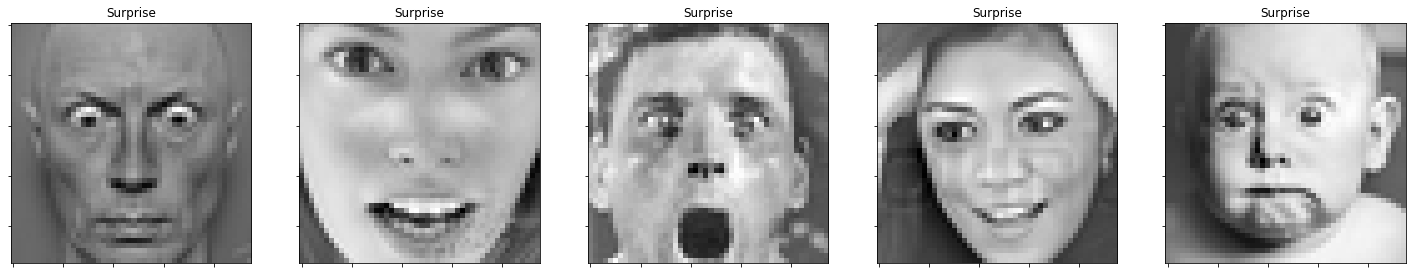

In [20]:
plot_examples(label=5)

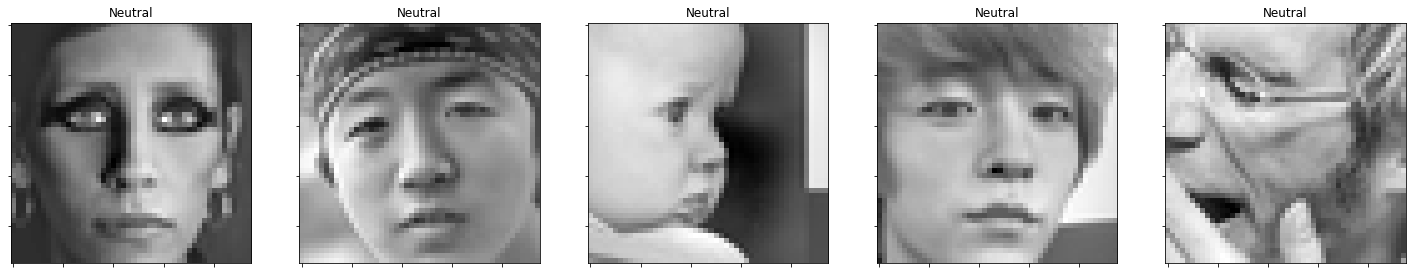

In [21]:
plot_examples(label=6)

In [22]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

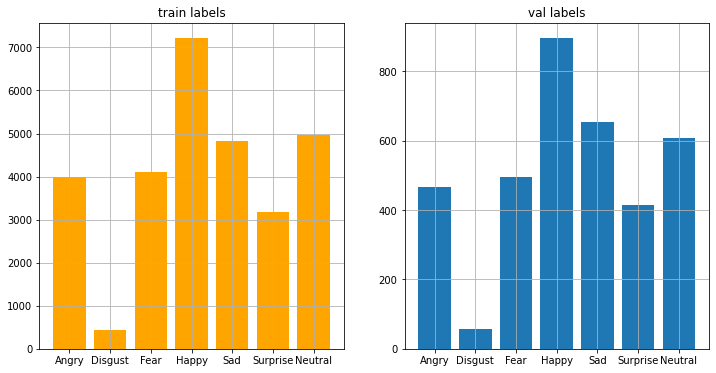

In [23]:
plot_compare_distributions(y_train, y_test, title1='train labels', title2='val labels')

In [24]:
class_weight = dict(zip(range(0, 7), (((df[df[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(df[df[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [25]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 200
width, height = 48, 48

In [26]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 64)        36928     
                                                        

In [28]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor='val_accuracy', min_delta=0.005 , patience= 10, verbose= 1, mode='auto')
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')
call_back = [es, mc]

In [30]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=[es,mc])

fer_json = model.to_json()
with open("face_emotion.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("face_emotion.h5")

Epoch 1/200
449/449 [==============================] - ETA: 0s - loss: 1.7172 - accuracy: 0.2943
Epoch 1: val_accuracy improved from -inf to 0.38813, saving model to best_model.h5
449/449 [==============================] - 33s 46ms/step - loss: 1.7172 - accuracy: 0.2943 - val_loss: 1.5407 - val_accuracy: 0.3881
Epoch 2/200
449/449 [==============================] - ETA: 0s - loss: 1.5134 - accuracy: 0.4092
Epoch 2: val_accuracy improved from 0.38813 to 0.44191, saving model to best_model.h5
449/449 [==============================] - 19s 43ms/step - loss: 1.5134 - accuracy: 0.4092 - val_loss: 1.4104 - val_accuracy: 0.4419
Epoch 3/200
449/449 [==============================] - ETA: 0s - loss: 1.4102 - accuracy: 0.4519
Epoch 3: val_accuracy improved from 0.44191 to 0.46838, saving model to best_model.h5
449/449 [==============================] - 19s 42ms/step - loss: 1.4102 - accuracy: 0.4519 - val_loss: 1.3328 - val_accuracy: 0.4684
Epoch 4/200
449/449 [==============================] - 

In [44]:
loaded_model = load_model('/content/drive/MyDrive/Section4Project/best_model.h5')
print(f"\n 테스트 정확도: {loaded_model.evaluate(X_test, y_test)[1]:.4f}")

113/113 [==============================] - 2s 12ms/step - loss: 1.1280 - accuracy: 0.5818

 테스트 정확도: 0.5818


In [32]:
h =  history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

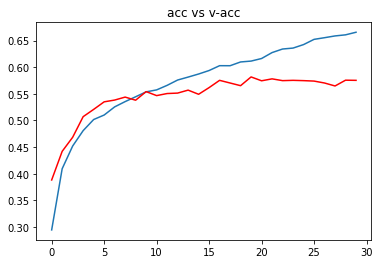

In [33]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

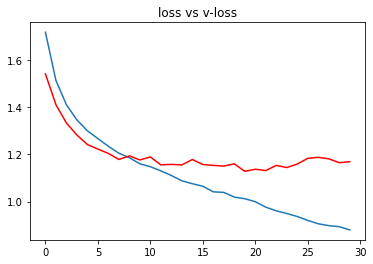

In [34]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [35]:
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = df[df['emotion']==i].index[i]
        axs[i].imshow(X_train[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[y_train[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [36]:
pred_test_labels = model.predict(X_test)

In [37]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

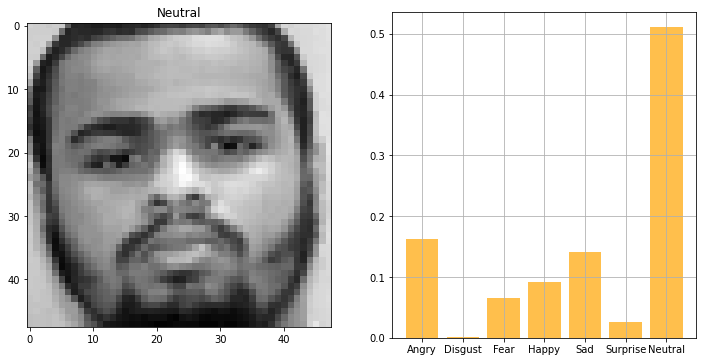

In [38]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

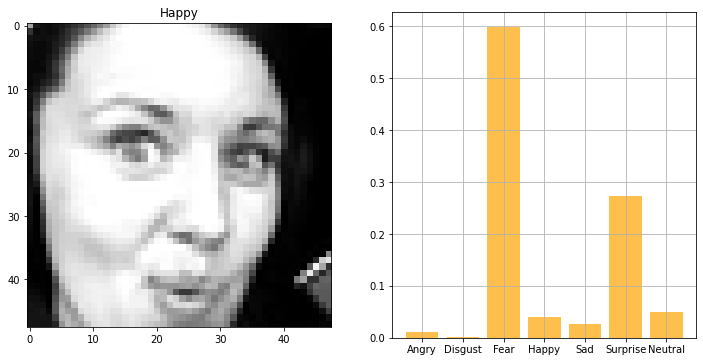

In [39]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 105)

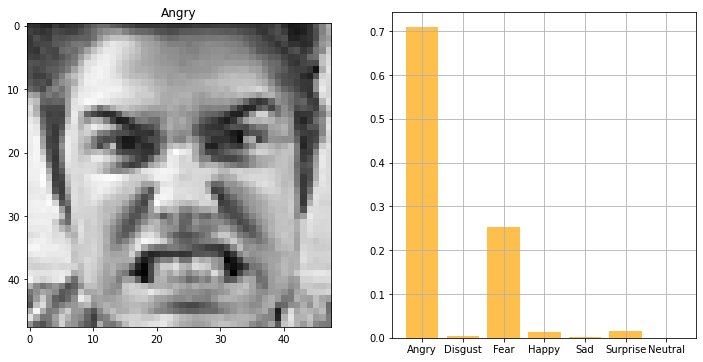

In [40]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

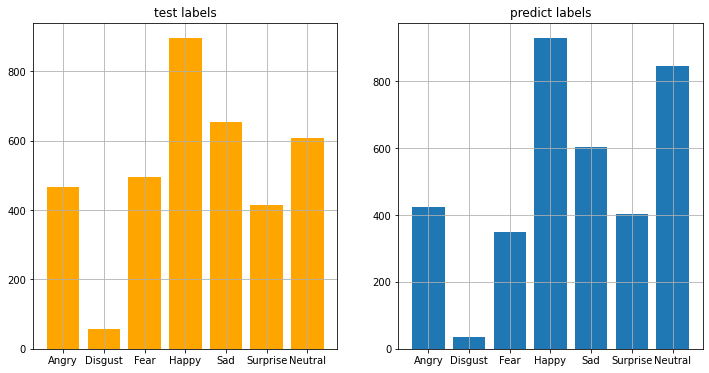

In [41]:
plot_compare_distributions(y_test, pred_test_labels, title1='test labels', title2='predict labels')

In [42]:
df_compare = pd.DataFrame()
df_compare['real'] = y_test.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

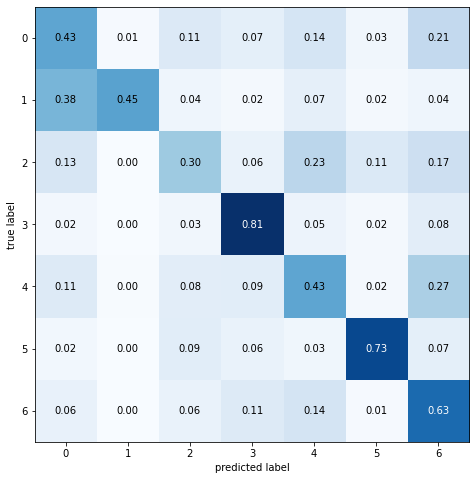

In [43]:
conf_mat = confusion_matrix(y_test.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed = True,
                                show_absolute = False,
                                figsize = (8, 8))
fig.show()